In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from IPython.display import Latex, display, Markdown

# Módszertan II
Befektetéselemzési, árampiaci és gázpiaci példákkal

## 1. Leíró statisztika

In [2]:
otp= yf.download('OTP.BD')

[*********************100%***********************]  1 of 1 completed


In [3]:
otp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-03-05,2100.0,2190.0,2082.0,2190.0,1611.094604,1726700
2002-03-06,2177.0,2251.0,2151.0,2240.0,1647.877563,898300
2002-03-07,2261.0,2300.0,2241.0,2295.0,1688.338867,763700
2002-03-08,2265.0,2282.0,2243.0,2280.0,1677.303955,402000
2002-03-11,2254.0,2259.0,2151.0,2159.0,1588.289185,439600


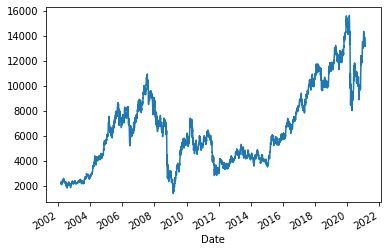

In [4]:
ax=otp.Close.plot()

In [5]:
#Hozam számolás
# egyszerű hozam
otp['simple_return'] = otp.Close.pct_change()
# log hozam
otp['log_return'] = np.log(otp.Close/otp.Close.shift(1))

In [6]:
otp.head()

,Open,High,Low,Close,Adj Close,Volume,simple_return,log_return
Date,,,,,,,,
2002-03-05,2100.0,2190.0,2082.0,2190.0,1611.094604,1726700,NaN,NaN
2002-03-06,2177.0,2251.0,2151.0,2240.0,1647.877563,898300,0.022831,0.022574
2002-03-07,2261.0,2300.0,2241.0,2295.0,1688.338867,763700,0.024554,0.024257
2002-03-08,2265.0,2282.0,2243.0,2280.0,1677.303955,402000,-0.006536,-0.006557
2002-03-11,2254.0,2259.0,2151.0,2159.0,1588.289185,439600,-0.053070,-0.054530


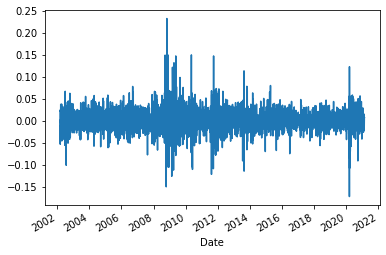

In [7]:
ax=otp.simple_return.plot()

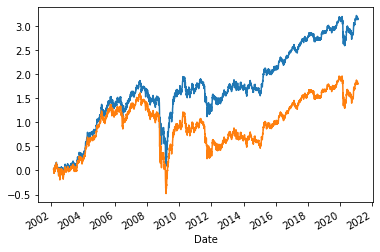

In [8]:
otp.simple_return.cumsum().plot()
ax=otp.log_return.cumsum().plot()

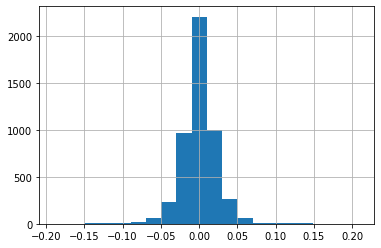

In [9]:
ax=otp.log_return.hist(bins=20)

In [10]:
otp.Close[0] * np.exp(len(otp)*otp.log_return.mean())

13354.957103741532

In [11]:
otp.Close[-1]

13350.0

In [12]:
otp.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume,simple_return,log_return
count,4870.00,4870.00,4870.00,4870.00,4870.00,4870.00,4869.00,4869.00
mean,6449.76,6525.55,6367.59,6447.86,5687.83,1280074.36,0.00,0.00
std,3118.94,3145.06,3093.45,3120.29,3233.33,1391901.95,0.02,0.02
min,1320.00,1500.00,1232.00,1355.00,1098.25,0.00,-0.17,-0.19
25%,4090.25,4138.25,4040.00,4090.00,3393.31,469129.50,-0.01,-0.01
50%,5821.00,5886.00,5750.00,5819.00,4891.77,850067.50,0.00,0.00
75%,8502.50,8599.75,8418.00,8497.75,7377.53,1581849.25,0.01,0.01
max,15580.00,15850.00,15520.00,15630.00,15630.00,26698424.00,0.23,0.21


In [13]:
print(f'Median:{otp.Close.median()} \nMode:\n{otp.Close.mode()}')

Median:5819.0 
Mode:
0    4150.0
1    4200.0
dtype: float64


Sűrűségfüggvény
$f(x)=\frac{1}{\sigma\sqrt{2\pi}}e^\frac{(x-m)^2}{2\sigma^2}$

# II. Rész: Villamosenergia day ahead árak és fogyasztás kapcsolatának vizsgálata
Ebben a részben a HUPX Day ahead árak és a magyar villamosenergia rendszer fogyasztási görbéjét vizsgálom, egy tetszőleges napra vonatkozólag. A DAM árak T-1 napi aukció során alakultak ki. 

In [14]:
# adatok letöltése az ENTSOE transparency platformról
# hupx jelöli a DAM árak tábláját, load pedig a terhelési adatokat.
import entsoapi
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key=entsoapi.mykey)

country_code = 'HU'
start = pd.Timestamp('202102150000', tz='Europe/Brussels')
end = pd.Timestamp('202102152345', tz='Europe/Brussels')

hupx = client.query_day_ahead_prices(country_code, start=start,end=end)
load=client.query_load(country_code, start=start,end=end)

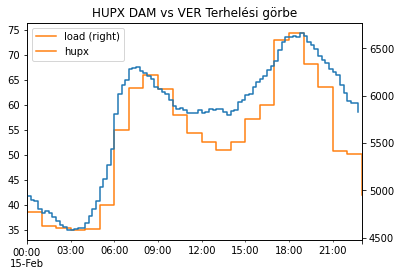

In [15]:
load.plot(secondary_y=True, drawstyle='steps-post', label='load', legend=True)
a = hupx.plot(drawstyle='steps-post', label='hupx', legend=True, 
              title =f'HUPX DAM vs VER Terhelési görbe')

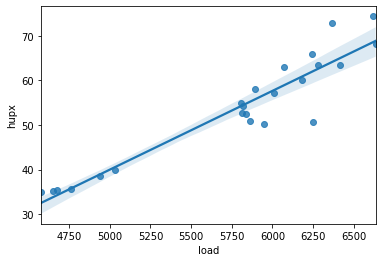

In [16]:
df = pd.DataFrame()
df['load'] = load
df['hupx'] = hupx
df.dropna(inplace=True)
ax = sns.regplot(x="load", y="hupx", data=df)

## Kétváltozós lineáris regressziós modell (kézi számolással)

X tengelyen a terhelési görbe ami az okozó tényező Y tengelyen a hupx DA árak.

$Y = \beta_0 + \beta_1X$

### Legkisebb négyzetek módszere
Munkatábla; az idősor tengelyre nincs szükség.

In [17]:
#X = load; Y= hupx
df['XiYi'] = df.load*df.hupx
df['Xi2'] = df.load*df.load
df.dropna()
df.head(3)

,load,hupx,XiYi,Xi2
2021-02-15 00:00:00+01:00,4942.0,38.53,190415.26,24423364.0
2021-02-15 01:00:00+01:00,4764.0,35.70,170074.80,22695696.0
2021-02-15 02:00:00+01:00,4676.0,35.42,165623.92,21864976.0


### Normálegyenletek megoldása determináns módszerrel

In [18]:
sumY = df.hupx.sum()
sumX2 = df['Xi2'].sum()
sumX = df.load.sum()
sumXY = df.XiYi.sum()
n = len(df)
b0= (sumY*sumX2-(sumX*sumXY))/(n*sumX2-(sumX*sumX))
b1 = (n*sumXY-sumY*sumX)/(n*sumX2-(sumX*sumX))
display(Latex(f'$\\beta_0:${b0:4f} $\\beta_1:${b1:4f}'))

<IPython.core.display.Latex object>

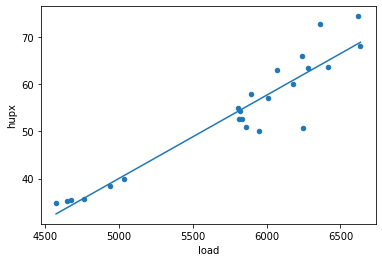

In [19]:
df.plot.scatter(x='load', y='hupx')
x_values = np.linspace(df.load.min(),df.load.max(),2)
y_linreg_values = b0+b1*x_values
ax=plt.plot(x_values,y_linreg_values)

In [20]:
print(f'A regressziófüggvény:Y = {b0:.2f} + {b1:.4f} X')
print(f'A villamosenergia fogyasztás 100 MWh-val való \
növekedése átlagosan {b1*100:.4f} EUR/MWh-val növelte \
a HUPX DA árait a vizsgált időszakban.')

A regressziófüggvény:Y = -48.28 + 0.0177 X
A villamosenergia fogyasztás 100 MWh-val való növekedése átlagosan 1.7656 EUR/MWh-val növelte a HUPX DA árait a vizsgált időszakban.
